In [95]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [96]:
 !ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


we have files in pickle format like train.p

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
import pickle
import pandas as pd
import random

In [0]:
np.random.seed(0)

In [99]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data=pickle.load(f)
with open('german-traffic-signs/valid.p','rb') as f:
  val_data=pickle.load(f) 
with open('german-traffic-signs/test.p','rb') as f:
  test_data=pickle.load(f)
print(type(train_data))
x_train,y_train = train_data['features'],train_data['labels']
x_val,y_val = val_data['features'],val_data['labels']
x_test,y_test = test_data['features'],test_data['labels']


<class 'dict'>


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen=ImageDataGenerator(width_shift_range=0.1,
                  height_shift_range=0.1,
                  zoom_range=0.2,
                  shear_range=0.1,
                  rotation_range=10)
datagen.fit(x_train)

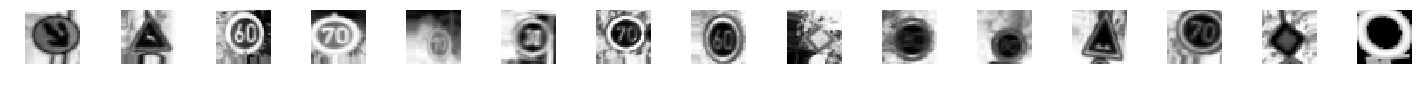

In [141]:
batches=datagen.flow(x_train,y_train,batch_size=20)
x_batch,y_batch=next(batches)

fig,axs=plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(x_batch[i].reshape(32,32))
  axs[i].axis("off")

In [100]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(x_train.shape[0]==y_train.shape[0]),"no of images is not equal to labels"
assert(x_val.shape[0]==y_val.shape[0]),"no of images is not equal to labels"
assert(x_test.shape[0]==y_test.shape[0]),"no of images is not equal to labels"


In [0]:
data=pd.read_csv("german-traffic-signs/signnames.csv")
no_of_samples=[]
cols=5
no_classes=43
fig,axs=plt.subplots(nrows=no_classes,ncols=cols,figsize=(5,50))
fig.tight_layout()

for i in range(cols):
  for j,row in data.iterrows():
    x_selected=x_train[y_train==j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected)-1)), :, :],cmap=plt.get_cmap("gray"))
    axs[j][i].axis("off")
    if i==2:
      axs[j][i].set_title(str(j) + "-"+ row["SignName"])
      no_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


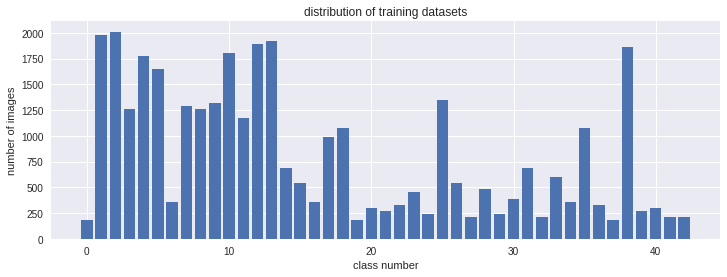

In [103]:
print(no_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0,no_classes),no_of_samples)
plt.title("distribution of training datasets")
plt.xlabel("class number")
plt.ylabel("number of images")
plt.show()

(32, 32, 3)
36


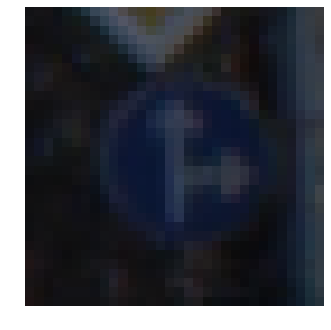

In [104]:
import cv2
plt.imshow(x_train[1000])
plt.axis("off")
print(x_train[1000].shape)
print(y_train[1000])

(32, 32)


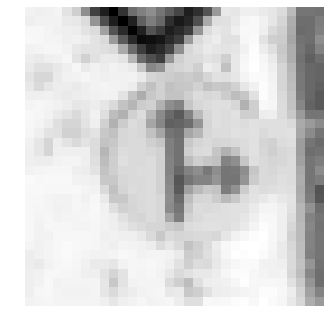

In [105]:
def grayscale(img):
  gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  return gray
img=grayscale(x_train[1000])
plt.axis("off")
plt.imshow(img)
print(img.shape)

(32, 32)


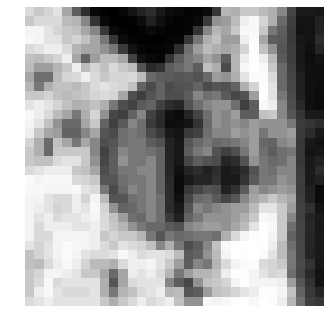

In [106]:
def equalize(img):
  equalimg=cv2.equalizeHist(img) #equalizeHist() distribute the color brightness
                                 #to all part of the image 
  return equalimg
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img
x_train=np.array(list(map(preprocessing,x_train)))
x_val=np.array(list(map(preprocessing,x_val)))
x_test=np.array(list(map(preprocessing,x_test)))


(34799, 32, 32)


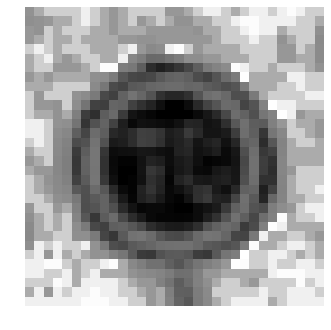

In [108]:
plt.imshow(x_train[random.randint(0,len(x_train)-1)])
plt.axis("off")
print(x_train.shape)

In [0]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[1],1)
x_val=x_val.reshape(x_val.shape[0],x_val.shape[1],x_val.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[1],1)


In [110]:
print(x_train.shape)

(34799, 32, 32, 1)


In [0]:
y_train=to_categorical(y_train,43)
y_test=to_categorical(y_test,43)
y_val=to_categorical(y_val,43)

In [112]:
y_train.shape

(34799, 43)

In [0]:
def leNet_model():
  model=Sequential()
  model.add(Conv2D(60,(5,5),input_shape=(32,32,1),activation="relu"))
  model.add(Conv2D(60,(5,5),activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
  model.add(Conv2D(30,(3,3),activation="relu"))
  model.add(Conv2D(30,(3,3),activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(500,activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(no_classes,activation="softmax"))
  model.compile(Adam(lr=0.001),loss="categorical_crossentropy",metrics=["accuracy"])
  return model

In [132]:
model=leNet_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 14, 14, 60)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 30)        16230     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 6, 6, 30)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 1080)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 500)               540500    
_________________________________________________________________
dropout_9 (Dropout)          (None, 500)               0         
__________

In [152]:
history=model.fit_generator(datagen.flow(x_train, y_train,batch_size=50),steps_per_epoch=2000,validation_data = (x_val,y_val),epochs = 10, shuffle = 1)

Epoch 1/10
1050/2000 [==============>...............] - ETA: 1:47 - loss: 1.0829 - acc: 0.6680

KeyboardInterrupt: ignored

In [0]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["training","validation"])
plt.title("Accuracy")
plt.xlabel("epochs")

In [0]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.legend(["training","validation"])
plt.title("Accuracy")
plt.xlabel("epochs")


In [0]:
score=model.evaluate(x_test,y_test,verbose=0)
print("test score",score[0])